In [1]:
import os

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
LANGSMITH_PROJECT = os.getenv("LANGSMITH_PROJECT")
HUGGINGFACE_API_KEY = os.getenv("HUGGINGFACE_API_KEY")
SERPER_API_KEY = os.getenv("SERPER_API_KEY")

os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["GROQ_API_KEY"] = GROQ_API_KEY
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGSMITH_PROJECT"] = LANGSMITH_PROJECT
os.environ["HUGGINGFACE_API_KEY"] = HUGGINGFACE_API_KEY
os.environ["SERPER_API_KEY"] = SERPER_API_KEY

In [4]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_community.embeddings import HuggingFaceHubEmbeddings
from google import genai

/Users/atharvabot7/Downloads/MLOPS-Tutorials/LangGraph/langgraph/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
embeddings = GoogleGenerativeAIEmbeddings(
    model="models/text-embedding-004"
)

In [6]:
from langchain_groq import ChatGroq

llm = ChatGroq(model_name = "llama-3.3-70b-versatile")

In [7]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [8]:
loader = DirectoryLoader(
    path="data",
    glob="info3.txt",       
    loader_cls=TextLoader   
)

In [9]:
docs = loader.load()

In [10]:
docs

[Document(metadata={'source': 'data/info3.txt'}, page_content='India’s economy in 2025 stands as one of the fastest growing in the world, projected at approximately $4.2 trillion in nominal GDP and maintaining an annual growth rate of 6.3% to 6.5%, making it the fourth largest globally in nominal terms and the third largest in purchasing power parity. This momentum is driven by robust domestic consumption, rising foreign direct investment, government-backed infrastructure programs, and the increasing digitization of both urban and rural sectors. Major initiatives such as the National Infrastructure Pipeline and the PM Gati Shakti masterplan are catalyzing manufacturing growth, logistics optimization, and multimodal connectivity across the country, while the Union Budget 2025 has introduced sweeping tax changes, including zero income tax up to ₹12 lakh (₹12.75 lakh with standard deduction), increased TDS thresholds, and longer filing windows to enhance compliance ease. Alongside these d

In [11]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 100,
    chunk_overlap = 50
)

In [12]:
new_docs = text_splitter.split_documents(documents=docs)

In [13]:
doc_strings = [doc.page_content for doc in new_docs]

In [14]:
db = Chroma.from_documents(new_docs, embedding=embeddings) 
retriever = db.as_retriever(search_kwargs={"k":3})

In [15]:
query = "what is Indian economy?"
docs = retriever.get_relevant_documents(query)
print(docs[0].metadata)
print(docs[0].page_content)

for doc in docs:
    print(doc)

/var/folders/p_/v95prvpj4cz7y53gvmgm1d_r0000gn/T/ipykernel_42020/2809331465.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(query)


{'source': 'data/info3.txt'}
India’s position as the fastest-growing major economy, even amidst global economic headwinds,
page_content='India’s position as the fastest-growing major economy, even amidst global economic headwinds,' metadata={'source': 'data/info3.txt'}
page_content='India’s economy in 2025 stands as one of the fastest growing in the world, projected at' metadata={'source': 'data/info3.txt'}
page_content='and enhancing India’s global investment appeal, positioning the Indian economy not only as' metadata={'source': 'data/info3.txt'}


In [16]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage
from langchain.prompts import PromptTemplate

In [17]:
class AgentState(TypedDict):
    """ 
    The 'message' field should be a sequence of strings, and we annotate it with 'operator.add'.
    This implies we might want to "add" new messages to the sequence later.
    """
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [18]:
from pydantic import BaseModel, Field

class TopicSelectionParser(BaseModel):
    Topic: str = Field(description='Selected Topic')
    Reasoning: str = Field(description='Reasoning behind topic selection')

In [19]:
from langchain.output_parsers import PydanticOutputParser

parser = PydanticOutputParser(pydantic_object = TopicSelectionParser)

In [20]:
def function_1(state):
    message=state["messages"]
    question=message[-1]
    print(question)
    
    template="""
    Your task is to classify the given user query into one of the following categories: [India, Not Related]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """
    
    prompt = PromptTemplate(template=template,
                                    input_variables=[question],
                                    partial_variables={
                                        "format_instructions" : parser.get_format_instructions()                                    }
                                    )
    chain =  prompt | llm | parser
    
    response = chain.invoke({"question":question,"format_instructions" : parser.get_format_instructions() })

    print(response)

    return {"messages": [response.Topic]}

In [21]:
def router(state):
    print('-> Router ->')
    
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    if 'India' in last_message:
        return 'RAG Call'
    else:
        return 'LLM Call'

In [22]:
def function_2(state):
    print('-> Calling RAG ->')
    messages = state['messages']
    question = messages[0] ## Fetching the user question
    print(question)

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)
    
    print(prompt)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return  {"messages": [result]}

In [23]:
def function_3(state):
    print('-> Calling LLM ->')

    messages = state['messages']
    question = messages[0] ## Fetching the user question

    # Normal LLM call
    complete_query = "Anwer the follow question with your knowledge of the real world. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}

In [24]:
from langgraph.graph import StateGraph,END

workflow5 = StateGraph(AgentState) ### StateGraph with AgentState


workflow5.add_node("agent", function_1)

workflow5.add_node("RAG", function_2)

workflow5.add_node("LLM", function_3)


workflow5.set_entry_point("agent")

workflow5.add_conditional_edges(
    "agent",
    
    
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
    }
)

workflow5.add_edge("RAG",END)


workflow5.add_edge("LLM",END)


app5=workflow5.compile()

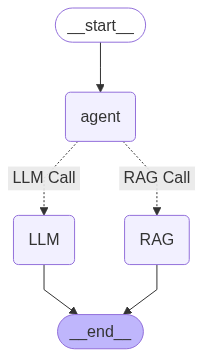

In [25]:
from IPython.display import Image, display

try:
    display(Image(app5.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [26]:
inputs = {"messages": ["Tell me about India's Industrial Growth"]}

In [27]:
output = app5.invoke(inputs)

Tell me about India's Industrial Growth
Topic='India' Reasoning="The user query mentions India's Industrial Growth, which is directly related to the country."
-> Router ->
India
-> Calling RAG ->
Tell me about India's Industrial Growth
input_variables=['context', 'question'] input_types={} partial_variables={} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only on the following context:\n    {context}\n\n    Question: {question}\n    '), additional_kwargs={})]


In [28]:
output

{'messages': ["Tell me about India's Industrial Growth",
  'India',
  "According to the information, India's economy, which includes its industrial growth, is projected to be one of the fastest-growing in the world in 2025. Additionally, initiatives like the Infrastructure Pipeline and the PM Gati Shakti masterplan are catalyzing manufacturing growth, contributing to the country's overall industrial development."]}

In [29]:
inputs1 = {"messages": ["Tell me about John Wick"]}

In [30]:
output1 = app5.invoke(inputs1)

Tell me about John Wick
Topic='Not Related' Reasoning='The user query is about John Wick, which is not related to India'
-> Router ->
Not Related
-> Calling LLM ->


In [31]:
output1

{'messages': ['Tell me about John Wick',
  'Not Related',
  "John Wick is a fictional character and the protagonist of a popular action-thriller film franchise. He is portrayed by Keanu Reeves, who plays a retired hitman with a unique set of skills and a penchant for taking down his enemies.\n\nThe first John Wick film, released in 2014, introduces us to the character, a retired hitman who has lost his wife to illness. He receives a gift from his wife, a Beagle puppy named Daisy, to help him cope with his grief. However, his peaceful life is disrupted when a group of thugs, led by Iosef Tarasov (Alfie Allen), break into his home, steal his vintage Mustang, and kill his dog. This sets off a chain of events as John Wick seeks revenge against the thugs and their powerful crime lord father, Viggo Tarasov (Michael Nyqvist).\n\nThe film's success led to the creation of a franchise, with three more films: John Wick: Chapter 2 (2017), John Wick: Chapter 3 – Parabellum (2019), and John Wick: Ch